In [33]:
import numpy as np
import jax

import matplotlib.pyplot as plt

In [41]:
def _cross2(a, b):
    # 2D cross product (scalar): a_x b_y - a_y b_x
    return a[..., 0] * b[..., 1] - a[..., 1] * b[..., 0]


def _on_segment(a, b, p, eps=1e-12):
    # p collinear with segment ab and within bounding box
    min_ab = jax.numpy.minimum(a, b) - eps
    max_ab = jax.numpy.maximum(a, b) + eps
    return jax.numpy.logical_and(
        jax.numpy.all(p >= min_ab),
        jax.numpy.all(p <= max_ab)
    )


def _seg_intersect(a, b, c, d, eps=1e-12):
    """
    Segment AB intersects segment CD (including touching/overlap).
    a,b,c,d: (2,) arrays
    """
    ab = b - a
    ac = c - a
    ad = d - a
    cd = d - c
    ca = a - c
    cb = b - c

    o1 = _cross2(ab, ac)
    o2 = _cross2(ab, ad)
    o3 = _cross2(cd, ca)
    o4 = _cross2(cd, cb)

    intersection = jax.numpy.logical_and(o1 * o2 < -eps, o3 * o4 < -eps)
    return intersection


def _point_in_triangle(p, tri, eps=1e-12):
    """
    Point p inside (or on boundary of) triangle tri using same-side test.
    Works best for non-degenerate triangles.
    """
    a, b, c = tri
    ab = b - a
    bc = c - b
    ca = a - c

    ap = p - a
    bp = p - b
    cp = p - c

    c1 = _cross2(ab, ap)
    c2 = _cross2(bc, bp)
    c3 = _cross2(ca, cp)

    # p is inside if all cross products are non-negative or all non-positive
    has_pos = (c1 > eps) | (c2 > eps) | (c3 > eps)
    has_neg = (c1 < -eps) | (c2 < -eps) | (c3 < -eps)
    return jax.numpy.logical_not(jax.numpy.logical_and(has_pos, has_neg))


@jax.jit
def triangles_intersect(t0, t1, eps=1e-12):
    """
    t0, t1: (3,2) float arrays
    Returns True if triangles intersect (including touching).
    """
    intersection = False

    # 1) Edge-edge intersections
    e0 = [(t0[i], t0[(i + 1) % 3]) for i in range(3)]
    e1 = [(t1[i], t1[(i + 1) % 3]) for i in range(3)]
    for a, b in e0:
        for c, d in e1:
            intersection = intersection | _seg_intersect(a, b, c, d, eps=eps)

    # 2) Containment (one inside the other)
    intersection = intersection | _point_in_triangle(t0[0], t1, eps=eps)
    intersection = intersection | _point_in_triangle(t1[0], t0, eps=eps)

    return intersection

In [52]:
import jax
import jax.numpy as jnp

def _edge_normals(tri):
    # tri: (3,2)
    tri_next = jnp.roll(tri, shift=-1, axis=0)
    e = tri_next - tri  # (3,2) edges
    # perpendiculars (normals); direction/normalization does not matter for SAT comparisons
    n = jnp.stack([-e[:, 1], e[:, 0]], axis=1)  # (3,2)
    return n

@jax.jit
def triangles_intersect_strict_sat(t0, t1, eps=1e-12):
    """
    Strict triangle intersection:
    - returns True for overlaps with positive area (including containment),
    - returns False for "touching only" (shared edge/vertex contact) and separated cases.
    """
    # Build SAT axes (6,2)
    axes = jnp.concatenate([_edge_normals(t0), _edge_normals(t1)], axis=0)  # (6,2)

    # Project vertices onto axes:
    # proj: (3,6) where proj[i, k] = dot(t[i], axes[k])
    proj0 = t0 @ axes.T
    proj1 = t1 @ axes.T

    min0 = proj0.min(axis=0)
    max0 = proj0.max(axis=0)
    min1 = proj1.min(axis=0)
    max1 = proj1.max(axis=0)

    # Strict overlap on all axes: max0 > min1 AND max1 > min0
    # eps enforces "not just touching" numerically.
    overlap_strict = (max0 > min1 + eps) & (max1 > min0 + eps)
    return jnp.all(overlap_strict)

In [67]:
t0 = np.random.normal(size=(3, 2))
t1 = np.random.normal(size=(3, 2))
triangles_intersect_strict_sat(t0, t1, eps=1e-8)

Array(False, dtype=bool)

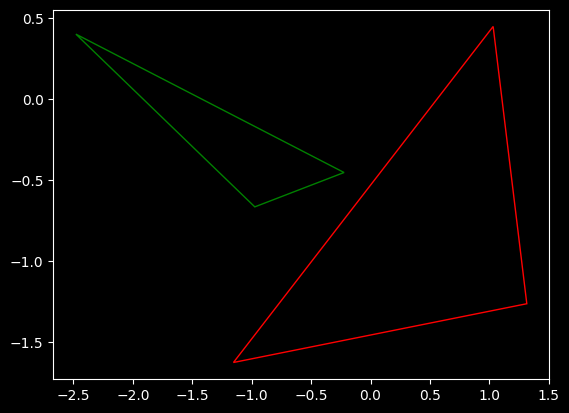

In [68]:
plt.fill(*t0.T, facecolor="none", edgecolor="red")
plt.fill(*t1.T, facecolor="none", edgecolor="green")